{{title_its_nb4}}

{{intro}}
In the previous notebook, we walked through initial steps to read and organize a large raster dataset, and to understand it in the context of spatial areas of interest represented by vector data. In this notebook, we will continue performing initial data inspection and exploratory analysis but this time, focused on velocity data clipped to an individual glacier. We examine velocity variability at the scale of a single glacier while demonstrating Xarray functionality for common computations and visualizations 

::::{tab-set}
:::{tab-item} Outline

(content:Section_A)=
**[A. Data exploration](#a-data-exploration)**
- {{a1_its_nb4}}
- {{a2_its_nb4}}
- {{a3_its_nb4}}

(content:Section_B)=
**[B. Comparing different satellites](#b-comparing-different-satellites)**
- {{b1_its_nb4}}
- {{b2_its_nb4}}

(content:Section_C)=
**[C. Examine velocity variability](#c-examine-velocity-variability)**
- {{c1_its_nb4}}
- {{c2_its_nb4}}
- {{c3_its_nb4}}

(content:section_D)=
**[D. Computations  along time dimension](#d-computations--along-time-dimension)**
- {{d1_its_nb4}}
- {{d2_its_nb4}}
:::

:::{tab-item} Learning Goals

{{concepts}}
- Examining metadata, interpreting physical observable in the context of available metadata,
- Sub-setting and visualizing raster datasets
- 'Split-apply-combine' workflows,
- Calculating summary statistics across given dimensions of a dataset,
- Performing reductions across multi-dimensional datasets.

{{techniques}}
- Managing groups of Xarray objects with `Xarray.DataTree`,  
- Grouped computations with `GroupBy`,  
- Using matplotlib to visualize raster and vector data with satellite imagery basemaps,   
- Combining Xarray with statistical packages like [SciPy](https://scipy.org/).

:::
::::

{{break}}

Expand the next cell to see specific packages used in this notebook and relevant system and version information. 

In [1]:
%xmode minimal
import warnings

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import scipy.stats
import xarray as xr

warnings.simplefilter(action="ignore", category=FutureWarning)

Exception reporting mode: Minimal


Like in the previous notebook, we will write some objects to disk. Create the same variable to store the path to the root directory for this tutorial.

In [2]:
cwd = pathlib.Path.cwd()
tutorial1_dir = pathlib.Path(cwd).parent

{{break}}

## A. Data exploration

### {{a1_its_nb4}}

In [3]:
# Read raster
single_glacier_raster = xr.open_zarr("../data/raster_data/single_glacier_itslive.zarr", decode_coords="all", chunks=None)
# Read vector
single_glacier_vector = gpd.read_file("../data/vector_data/single_glacier_vec.json")

We can also drop variables we won't be using:

In [4]:
vars_to_keep = ['v','vx','vy','v_error','vy_error','vx_error','acquisition_date_img1','acquisition_date_img2','satellite_img1','satellite_img2']
single_glacier_raster = single_glacier_raster[vars_to_keep]

In [5]:
# Take a look at raster data object
single_glacier_raster

<xarray.Dataset> Size: 1GB
Dimensions:                (mid_date: 47892, y: 37, x: 40)
Coordinates:
    mapping                int64 8B ...
  * mid_date               (mid_date) datetime64[ns] 383kB 1986-09-11T03:31:1...
    spatial_ref            int64 8B ...
  * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
  * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
Data variables:
    v                      (mid_date, y, x) float32 284MB ...
    vx                     (mid_date, y, x) float32 284MB ...
    vy                     (mid_date, y, x) float32 284MB ...
    v_error                (mid_date, y, x) float32 284MB ...
    vy_error               (mid_date) float32 192kB ...
    vx_error               (mid_date) float32 192kB ...
    acquisition_date_img1  (mid_date) datetime64[ns] 383kB ...
    acquisition_date_img2  (mid_date) datetime64[ns] 383kB ...
    satellite_img1         (mid_date) <U2 383kB ...
    satellite_img2         (mid_date) <U2 383kB ...
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [6]:
single_glacier_raster.nbytes / 1e9

1.136382008

In [7]:
np.unique(single_glacier_raster.satellite_img1)

array(['1A', '2A', '2B', '4', '5', '7', '8', '9'], dtype='<U2')

In [8]:
np.unique(single_glacier_raster.satellite_img2)

array(['1A', '2A', '2B', '4', '5', '7', '8', '9'], dtype='<U2')

The above code cells show us that this dataset contains observations from Sentinel 1 & 2 and Landsat 4,5,6,7,8 & 9 satellite sensors. The dataset is 1.1 GB. 

In [9]:
single_glacier_raster

<xarray.Dataset> Size: 1GB
Dimensions:                (mid_date: 47892, y: 37, x: 40)
Coordinates:
    mapping                int64 8B ...
  * mid_date               (mid_date) datetime64[ns] 383kB 1986-09-11T03:31:1...
    spatial_ref            int64 8B ...
  * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
  * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
Data variables:
    v                      (mid_date, y, x) float32 284MB ...
    vx                     (mid_date, y, x) float32 284MB ...
    vy                     (mid_date, y, x) float32 284MB ...
    v_error                (mid_date, y, x) float32 284MB ...
    vy_error               (mid_date) float32 192kB ...
    vx_error               (mid_date) float32 192kB ...
    acquisition_date_img1  (mid_date) datetime64[ns] 383kB ...
    acquisition_date_img2  (mid_date) datetime64[ns] 383kB ...
    satellite_img1         (mid_date) <U2 383kB '5' '5' '5' ... '2B' '2B' '2B'
    satellite_img2         (mid_date) <U2 383kB '5' '5' '5' ... '2B' '2B' '2B'
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

As a quick sanity check, we'll convince ourselves that the clipping operation in the previous [notebook](initial_velocity_data_inspection.ipynb#A.-Crop-ITS_LIVE-granule-single-glacier-outline) worked correctly. We also show that we can plot both Xarray raster data and GeoPandas vector data overlaid on the same plot with a satellite image basemap as a background.

A few notes about the following figure:
- `single_glacier_raster` is a 3-dimensional object. We want to plot it in 2-d space with the RGI glacier outline. So, we perform a reduction (in this case, compute the mean), in order to reduce the dataset from 3-d to 2-d (Another option would be to select a single time step).
- We could make this plot with a white background, but it is also nice to be able to add a base map to the image. Here, we'll use [contextily](https://contextily.readthedocs.io/en/latest/) to do so. This will require converting the coordinate reference system (CRS) of both objects to the Web Mercator projection (EPSG:3857).

In [10]:
# Check that CRS of vector and raster data are the same
assert single_glacier_raster.rio.crs == single_glacier_vector.crs

AssertionError: 

In [11]:
single_glacier_raster = single_glacier_raster.rio.write_crs(single_glacier_raster.attrs["projection"])

In [12]:
# Check that CRS of vector and raster data are the same
assert single_glacier_raster.rio.crs == single_glacier_vector.crs

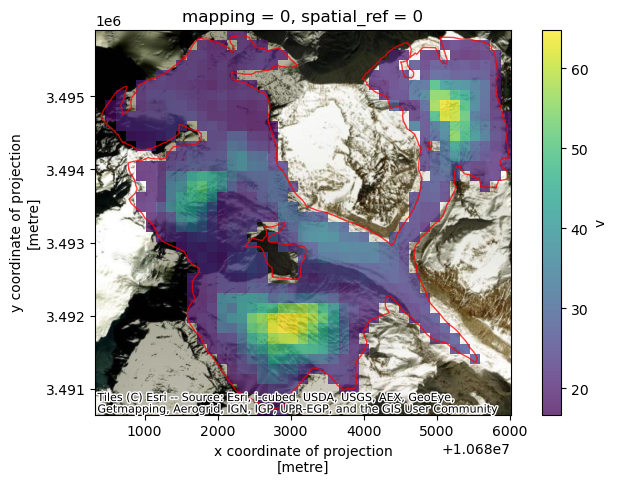

In [13]:
# Reproject both objects to web mercator
single_glacier_vector_web = single_glacier_vector.to_crs("EPSG:3857")
single_glacier_raster_web = single_glacier_raster.rio.reproject("EPSG:3857")

fig, ax = plt.subplots(figsize=(8, 5))

# Plot objects
single_glacier_raster_web.v.mean(dim="mid_date").plot(ax=ax, cmap="viridis", alpha=0.75, add_colorbar=True)
single_glacier_vector_web.plot(ax=ax, facecolor="None", edgecolor="red", alpha=0.75)
# Add basemap
cx.add_basemap(ax, crs=single_glacier_vector_web.crs, source=cx.providers.Esri.WorldImagery)

We sorted along the time dimension in the previous notebook, so it should be in chronological order.

In [14]:
single_glacier_raster.mid_date[:6].data

array(['1986-09-11T03:31:15.003252992', '1986-10-05T03:31:06.144750016',
       '1986-10-21T03:31:34.493249984', '1986-11-22T03:29:27.023556992',
       '1986-11-30T03:29:08.710132992', '1986-12-08T03:29:55.372057024'],
      dtype='datetime64[ns]')

### {{a2_its_nb4}}

A wide variety of forces can impact both satellite imagery and the ability of ITS_LIVE's feature tracking algorithm to extract velocity estimates from satellite image pairs. For these reasons, there are at times both gaps in coverage and ranges in the estimated error associated with different observations. The following section will demonstrate how to calculate and visualize coverage of the dataset over time. Part 2 will include a discussion of uncertainty and error estimates

When first investigating a dataset, it is helpful to be able to scan/quickly visualize coverage along a given dimension. To create the data needed for such a visualization, we first need a mask that will tell us all possible 'valid' pixels; in other words, we need to differentiate between pixels in our 2-d rectangular array that represent ice v. non-ice. Then, for every time step, we can calculate the portion of possible ice pixels that contain an estimated velocity value.

In [15]:
# calculate number of valid pixels
valid_pixels = single_glacier_raster.v.count(dim=["x", "y"])
# calculate max. number of valid pixels
valid_pixels_max = single_glacier_raster.v.notnull().any("mid_date").sum(["x", "y"])
# add cov proportion to dataset as variable
single_glacier_raster["cov"] = valid_pixels / valid_pixels_max

Now we can visualize coverage over time:

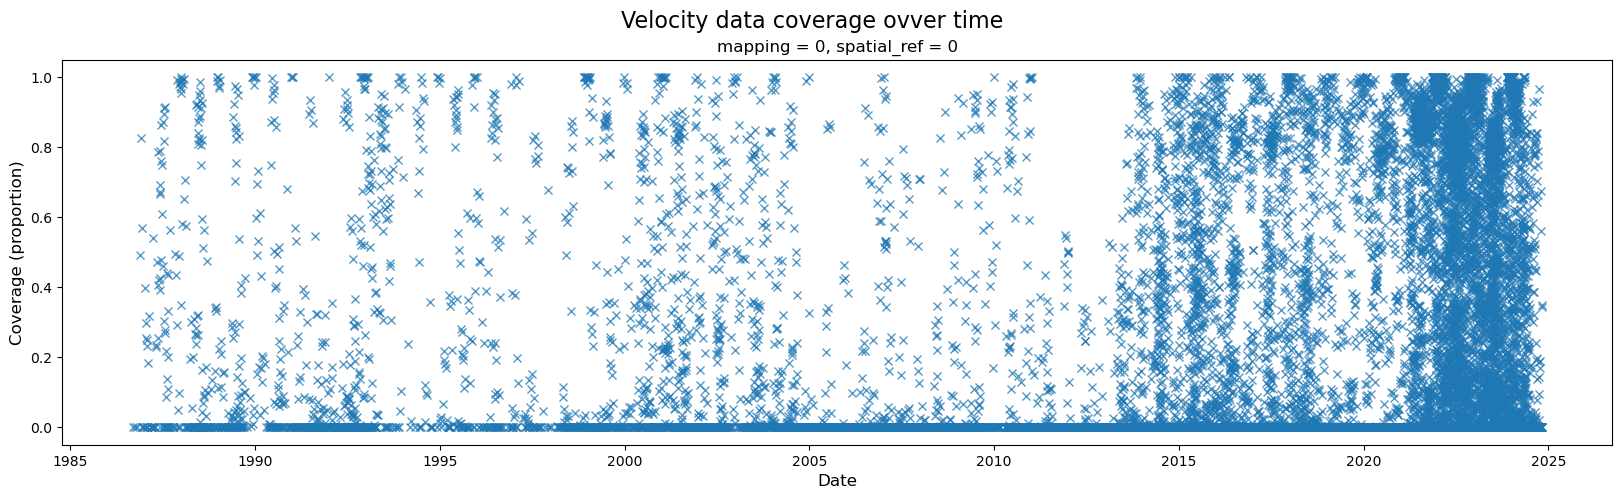

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))

# Plot object
single_glacier_raster["cov"].plot(ax=ax, linestyle="None", marker="x", alpha=0.75)

# Specify axes labels and title
fig.suptitle("Velocity data coverage ovver time", fontsize=16)
ax.set_ylabel("Coverage (proportion)", x=-0.05, fontsize=12)
ax.set_xlabel("Date", fontsize=12);

### {{a3_its_nb4}}

In this dataset, we have a dense time series of velocity observations for a given glacier (~48,000 observations from 1986-2024). However, we know that the ability of satellite imagery pairs to capture ice displacement (and by extension, velocity), can be impacted by conditions such as cloud-cover, which obscure Earth's surface from optical sensors. ITS_LIVE is a multi-sensor ice velocity dataset, meaning that it is composed of ice velocity observations derived from a number of satellites, which include both optical and Synthetic Aperture Radar (SAR) imagery. Currently, Sentinel-1 is the only SAR sensor included in ITS_LIVE, all others are optical. 

While optical imagery requires solar illumination and can be impacted by cloud cover, Sentinel-1 is an active remote sensing technique and images in a longer wavelength (C-band, ~ 5 cm). This means that Sentinel-1 imagery does not require solar illumination, and can penetrate through cloud cover. Because of these sensors differing sensitivity to Earth's surface conditions, there can sometimes be discrepancies in velocity data observed from different sensors. 

```{note}
There are many great resources available for understanding the principles of SAR and working with SAR imagery. Check out the SAR section of the [tutorial data](../../background/4_tutorial_data.md) for more detail and links to additional resources.
```

Let's first look at what sensors are represented in the time series:

In [17]:
sensors = np.unique(single_glacier_raster.satellite_img1.values).tolist()
sensors

['1A', '2A', '2B', '4', '5', '7', '8', '9']

To extract observations from a single satellite sensor, we will use Xarray indexing and selection methods such as `.where()` and `.sel()`. The following cells demonstrate different selection approaches and a brief discussion of the pros and cons of each when working with large and/ or sparse datasets.

#### Landsat 8
First, looking at velocity observations from Landsat8 data only:

In [18]:
%%time
l8_data = single_glacier_raster.where(single_glacier_raster["satellite_img1"] == "8", drop=True)
l8_data

CPU times: user 119 ms, sys: 120 ms, total: 239 ms
Wall time: 238 ms


<xarray.Dataset> Size: 64MB
Dimensions:                (mid_date: 2688, y: 37, x: 40)
Coordinates:
    mapping                int64 8B 0
  * mid_date               (mid_date) datetime64[ns] 22kB 2013-05-20T04:09:12...
  * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
  * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
    spatial_ref            int64 8B 0
Data variables:
    v                      (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vx                     (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vy                     (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    v_error                (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vy_error               (mid_date) float32 11kB 40.2 10.2 15.1 ... 26.5 159.6
    vx_error               (mid_date) float32 11kB 78.2 9.5 24.5 ... 17.5 100.5
    acquisition_date_img1  (mid_date) datetime64[ns] 22kB 2013-04-30T04:12:14...
    acquisition_date_img2  (mid_date) datetime64[ns] 22kB 2013-06-09T04:06:09...
    satellite_img1         (mid_date) object 22kB '8' '8' '8' ... '8' '8' '8'
    satellite_img2         (mid_date) object 22kB '7' '8' '7' ... '9' '9' '9'
    cov                    (mid_date) float64 22kB 0.0 0.5969 ... 0.0 0.3494
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Another approach: using `.sel()`:

In [19]:
%%time
l8_condition = single_glacier_raster.satellite_img1 == "8"
l8_data_alt = single_glacier_raster.sel(mid_date=l8_condition)
l8_data_alt

CPU times: user 17.4 ms, sys: 0 ns, total: 17.4 ms
Wall time: 16.8 ms


<xarray.Dataset> Size: 64MB
Dimensions:                (mid_date: 2688, y: 37, x: 40)
Coordinates:
    mapping                int64 8B 0
  * mid_date               (mid_date) datetime64[ns] 22kB 2013-05-20T04:09:12...
  * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
  * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
    spatial_ref            int64 8B 0
Data variables:
    v                      (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vx                     (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vy                     (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    v_error                (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vy_error               (mid_date) float32 11kB ...
    vx_error               (mid_date) float32 11kB ...
    acquisition_date_img1  (mid_date) datetime64[ns] 22kB ...
    acquisition_date_img2  (mid_date) datetime64[ns] 22kB ...
    satellite_img1         (mid_date) <U2 22kB '8' '8' '8' '8' ... '8' '8' '8'
    satellite_img2         (mid_date) <U2 22kB '7' '8' '7' '8' ... '9' '9' '9'
    cov                    (mid_date) float64 22kB 0.0 0.5969 ... 0.0 0.3494
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The approach using `.sel()` takes much less time than `.where()`. This is because `.sel()` queries the dataset using `mid_date` index. Xarray dimensions have associated `Index` objects, which are built on Pandas Indexes. They are very powerful for quickly and efficiently querying large datasets. In contrast, `.where()` must check each `satellite_img` data variable against the specified condition ('8'), which is not as efficient. 

#### What about a sensor with multiple identifiers?

For Landsat8 observations, we only needed to identify elements of the dataset where the `satellite_img1` variable matched a unique identifier, '8'. Sentinel-1 is a two-satellite constellation, meaning that it has sensors on board multiple satellites. For this, we need to select all observations where `satellite_img1` matches a list of possible values.

In [20]:
%%time
s1_condition = single_glacier_raster.satellite_img1.isin(["1A", "1B"])
s1_data = single_glacier_raster.sel(mid_date=s1_condition)
s1_data

CPU times: user 9.22 ms, sys: 0 ns, total: 9.22 ms
Wall time: 8.82 ms


<xarray.Dataset> Size: 9MB
Dimensions:                (mid_date: 362, y: 37, x: 40)
Coordinates:
    mapping                int64 8B 0
  * mid_date               (mid_date) datetime64[ns] 3kB 2014-10-16T11:41:02....
  * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
  * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
    spatial_ref            int64 8B 0
Data variables:
    v                      (mid_date, y, x) float32 2MB nan nan nan ... nan nan
    vx                     (mid_date, y, x) float32 2MB nan nan nan ... nan nan
    vy                     (mid_date, y, x) float32 2MB nan nan nan ... nan nan
    v_error                (mid_date, y, x) float32 2MB nan nan nan ... nan nan
    vy_error               (mid_date) float32 1kB ...
    vx_error               (mid_date) float32 1kB ...
    acquisition_date_img1  (mid_date) datetime64[ns] 3kB ...
    acquisition_date_img2  (mid_date) datetime64[ns] 3kB ...
    satellite_img1         (mid_date) <U2 3kB '1A' '1A' '1A' ... '1A' '1A' '1A'
    satellite_img2         (mid_date) <U2 3kB '1A' '1A' '1A' ... '1A' '1A' '1A'
    cov                    (mid_date) float64 3kB 0.9463 0.9604 ... 0.9958
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## B. Comparing different satellites

We've seen how to use Xarray's labeled dimensions and indexing and selection capabilities to subset the dataset based on its metadata. What if we wanted to use those subsets, for example to visualize data or perform computations for each subset group? We could do this manually, but it would be quite time-consuming and involve repeating the same steps for each group. Luckily, there are a few different ways that we can approach this without writing a lot of duplicate code. 

Below, we show two different approaches to split the dataset into subset based on a metadata condition, perform a calculation on each subset and then visualize the results for each subset side-by-side. 

Start by making a dict of each sensor and its identifying string(s):

In [21]:
sensor_conditions = {
    "Landsat 4": ["4"],
    "Landsat 5": ["5"],
    "Landsat 7": ["7"],
    "Landsat 8": ["8"],
    "Landsat 9": ["9"],
    "Sentinel 1": ["1A", "1B"],
    "Sentinel 2": ["2A", "2B"],
}

### {{b1_its_nb4}}

Rather than go through the above steps for each sensor, we write a function that subsets the dataset by sensor, returning a dict of Xarray datasets holding velocity time series for each sensor.

In [22]:
def separate_ds_by_sensor(ds, sensor_conditions):
    # Make empty lists to hold sensor IDs and subsetted datasets
    keys_ls, vals_ls = [], []

    # Iterate through each sensor in dict
    for sensor in sensor_conditions.keys():
        condition = ds.satellite_img1.isin(sensor_conditions[sensor])

        # Use .sel to subset data based on sensor
        sensor_data = ds.sel(mid_date=condition)

        keys_ls.append(f"{sensor}")
        vals_ls.append(sensor_data)

    # Return dict of sensor IDs and subsetted datasets
    ds_dict = dict(zip(keys_ls, vals_ls))
    return ds_dict

In [23]:
sensor_ds_dict = separate_ds_by_sensor(single_glacier_raster, sensor_conditions)
print(sensor_ds_dict.keys())

dict_keys(['Landsat 4', 'Landsat 5', 'Landsat 7', 'Landsat 8', 'Landsat 9', 'Sentinel 1', 'Sentinel 2'])


Take a look at one subset to see that it matches the one we made manually above:

In [24]:
sensor_ds_dict["Landsat 8"]

<xarray.Dataset> Size: 64MB
Dimensions:                (mid_date: 2688, y: 37, x: 40)
Coordinates:
    mapping                int64 8B 0
  * mid_date               (mid_date) datetime64[ns] 22kB 2013-05-20T04:09:12...
  * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
  * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
    spatial_ref            int64 8B 0
Data variables:
    v                      (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vx                     (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vy                     (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    v_error                (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vy_error               (mid_date) float32 11kB ...
    vx_error               (mid_date) float32 11kB ...
    acquisition_date_img1  (mid_date) datetime64[ns] 22kB ...
    acquisition_date_img2  (mid_date) datetime64[ns] 22kB ...
    satellite_img1         (mid_date) <U2 22kB '8' '8' '8' '8' ... '8' '8' '8'
    satellite_img2         (mid_date) <U2 22kB '7' '8' '7' '8' ... '9' '9' '9'
    cov                    (mid_date) float64 22kB 0.0 0.5969 ... 0.0 0.3494
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Now that we've separated the dataset into subset, we'd like a way to work with those subsets as a group, rather than applying operations to each one. For this, we can use a new structure within the Xarray data model, `xr.DataTree`, which facilitates working with collections of Xarray data objects. 

The use-case in this section is that we would like to efficiently compute the mean along the time dimension of the ITS_LIVE dataset for each satellite sensor, and then visualize the results.

Before the implementation of Xarray DataTree, we would need to either perform the sequence of operations on each sensor-specific dataset individually, or, create a dict of the sensor specific datasets, write a function to perform certain operations and either update the dictionary or create another to hold the results; both of these options are quite clunky and inefficient. 

We can create an `xr.DataTree` object by using the `from_dict()` method:


In [25]:
sensor_ds_tree = xr.DataTree.from_dict(sensor_ds_dict)

In [26]:
sensor_ds_tree

<xarray.DataTree>
Group: /
├── Group: /Landsat 4
│       Dimensions:                (mid_date: 12, y: 37, x: 40)
│       Coordinates:
│           mapping                int64 8B 0
│         * mid_date               (mid_date) datetime64[ns] 96B 1989-01-18T03:41:41....
│         * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
│         * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
│           spatial_ref            int64 8B 0
│       Data variables:
│           v                      (mid_date, y, x) float32 71kB nan nan nan ... nan nan
│           vx                     (mid_date, y, x) float32 71kB nan nan nan ... nan nan
│           vy                     (mid_date, y, x) float32 71kB nan nan nan ... nan nan
│           v_error                (mid_date, y, x) float32 71kB nan nan nan ... nan nan
│           vy_error               (mid_date) float32 48B ...
│           vx_error               (mid_date) float32 48B ...
│           acquisition_date_img1  (mid_date) datetime64[ns] 96B ...
│           acquisition_date_img2  (mid_date) datetime64[ns] 96B ...
│           satellite_img1         (mid_date) <U2 96B '4' '4' '4' '4' ... '4' '4' '4'
│           satellite_img2         (mid_date) <U2 96B '5' '5' '5' '5' ... '5' '5' '5'
│           cov                    (mid_date) float64 96B 0.9915 0.0 ... 0.4074 0.1004
│       Attributes: (12/19)
│           Conventions:                CF-1.8
│           GDAL_AREA_OR_POINT:         Area
│           author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
│           autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
│           datacube_software_version:  1.0
│           date_created:               25-Sep-2023 22:00:23
│           ...                         ...
│           s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
│           skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
│           time_standard_img1:         UTC
│           time_standard_img2:         UTC
│           title:                      ITS_LIVE datacube of image pair velocities
│           url:                        https://its-live-data.s3.amazonaws.com/datacu...
├── Group: /Landsat 5
│       Dimensions:                (mid_date: 2405, y: 37, x: 40)
│       Coordinates:
│           mapping                int64 8B 0
│         * mid_date               (mid_date) datetime64[ns] 19kB 1986-09-11T03:31:15...
│         * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
│         * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
│           spatial_ref            int64 8B 0
│       Data variables:
│           v                      (mid_date, y, x) float32 14MB nan nan nan ... nan nan
│           vx                     (mid_date, y, x) float32 14MB nan nan nan ... nan nan
│           vy                     (mid_date, y, x) float32 14MB nan nan nan ... nan nan
│           v_error                (mid_date, y, x) float32 14MB nan nan nan ... nan nan
│           vy_error               (mid_date) float32 10kB ...
│           vx_error               (mid_date) float32 10kB ...
│           acquisition_date_img1  (mid_date) datetime64[ns] 19kB ...
│           acquisition_date_img2  (mid_date) datetime64[ns] 19kB ...
│           satellite_img1         (mid_date) <U2 19kB '5' '5' '5' '5' ... '5' '5' '5'
│           satellite_img2         (mid_date) <U2 19kB '5' '5' '5' '5' ... '5' '5' '5'
│           cov                    (mid_date) float64 19kB 0.0 0.0 ... 0.05799 0.03253
│       Attributes: (12/19)
│           Conventions:                CF-1.8
│           GDAL_AREA_OR_POINT:         Area
│           author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
│           autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
│           datacube_software_version:  1.0
│           date

The DataTree has a parent node and groups (shown above) that contain individual `xr.Datasets`:

In [27]:
sensor_ds_tree["Landsat 8"].ds

<xarray.DatasetView> Size: 64MB
Dimensions:                (mid_date: 2688, y: 37, x: 40)
Coordinates:
    mapping                int64 8B 0
  * mid_date               (mid_date) datetime64[ns] 22kB 2013-05-20T04:09:12...
  * x                      (x) float64 320B 7.843e+05 7.844e+05 ... 7.889e+05
  * y                      (y) float64 296B 3.316e+06 3.316e+06 ... 3.311e+06
    spatial_ref            int64 8B 0
Data variables:
    v                      (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vx                     (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vy                     (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    v_error                (mid_date, y, x) float32 16MB nan nan nan ... nan nan
    vy_error               (mid_date) float32 11kB ...
    vx_error               (mid_date) float32 11kB ...
    acquisition_date_img1  (mid_date) datetime64[ns] 22kB ...
    acquisition_date_img2  (mid_date) datetime64[ns] 22kB ...
    satellite_img1         (mid_date) <U2 22kB '8' '8' '8' '8' ... '8' '8' '8'
    satellite_img2         (mid_date) <U2 22kB '7' '8' '7' '8' ... '9' '9' '9'
    cov                    (mid_date) float64 22kB 0.0 0.5969 ... 0.0 0.3494
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

If we want to perform a set of operations on every node of the Datatree, we can define a function to pass to `xr.DataTree.map_over_datasets()`:

In [28]:
def calc_temporal_mean(ds):
    """I'm a function that calculates the temporal mean of a dataset with (x,y,mid_date) dimensions.
    I return a new dataset with (x,y,sensor) dimensions"""

    # Skip parent node
    if len(ds.data_vars) == 0:
        return None

    else:
        # Calc mean
        tmean = ds.mean(dim="mid_date")
        # Add a sensor dimension -- this will be used for combining them back together later
        sensor = np.unique(ds.satellite_img1.data)
        if len(sensor) > 1:
            sensor = [sensor[0]]
        # Expand dims to add sensor
        tmean = tmean.expand_dims({"sensor": sensor})
        return tmean

In [29]:
temp_mean_tree = sensor_ds_tree.map_over_datasets(calc_temporal_mean)

Now, we can take just the descendent nodes of this Datatree:

In [30]:
child_tree = temp_mean_tree.descendants

and concatenate them into a single `xr.Dataset` along the `'sensor'` dimension we created above:

In [31]:
sensor_mean_ds = xr.concat([child_tree[i].ds for i in range(len(child_tree))], dim="sensor")

In [32]:
sensor_mean_ds

<xarray.Dataset> Size: 167kB
Dimensions:      (sensor: 7, y: 37, x: 40)
Coordinates:
  * sensor       (sensor) object 56B '4' '5' '7' '8' '9' '1A' '2A'
    mapping      int64 8B 0
  * x            (x) float64 320B 7.843e+05 7.844e+05 ... 7.888e+05 7.889e+05
  * y            (y) float64 296B 3.316e+06 3.316e+06 ... 3.312e+06 3.311e+06
    spatial_ref  int64 8B 0
Data variables:
    v            (sensor, y, x) float32 41kB nan nan nan nan ... nan nan nan nan
    vx           (sensor, y, x) float32 41kB nan nan nan nan ... nan nan nan nan
    vy           (sensor, y, x) float32 41kB nan nan nan nan ... nan nan nan nan
    v_error      (sensor, y, x) float32 41kB nan nan nan nan ... nan nan nan nan
    vy_error     (sensor) float32 28B 44.77 25.64 15.53 14.73 14.62 63.18 9.096
    vx_error     (sensor) float32 28B 51.84 25.74 22.2 18.88 10.68 108.9 6.172
    cov          (sensor) float64 56B 0.4351 0.254 0.07283 ... 0.5346 0.06737

Finally, we can use Xarray's `FacetGrid` plotting to visualize them side-by-side:

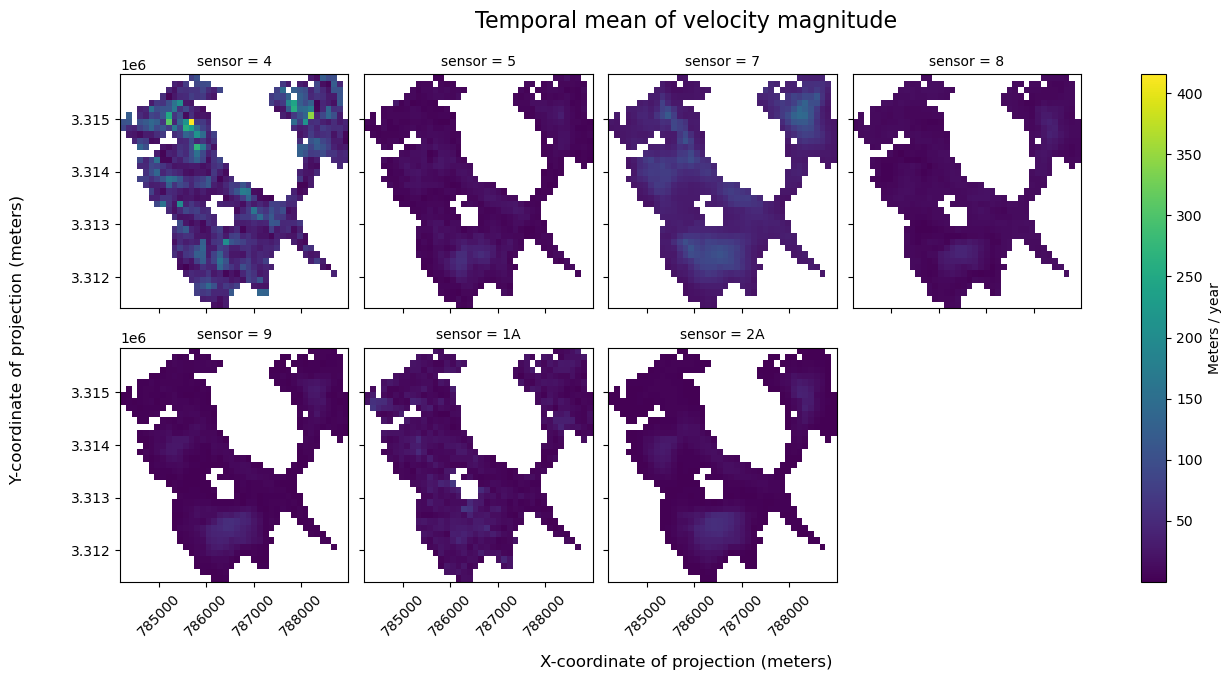

In [33]:
def calc_v_magnitude(ds):
    """I'm a function that calculates the magnitude of a velocity displacement vector given velocity component vectors.
    I return the same dataset object with a new variable called 'vmag'"""

    ds["vmag"] = np.sqrt(ds["vx"] ** 2 + ds["vy"] ** 2)
    return ds


# First, calculate magnitude of velocity from the temporal mean of the component vectors
sensor_mean_ds = calc_v_magnitude(sensor_mean_ds)

a = sensor_mean_ds["vmag"].plot(col="sensor", col_wrap=4, cbar_kwargs={"label": "Meters / year"})
a.fig.suptitle("Temporal mean of velocity magnitude", fontsize=16, y=1.05)
a.fig.supylabel("Y-coordinate of projection (meters)", fontsize=12, x=-0.02)
a.fig.supxlabel("X-coordinate of projection (meters)", fontsize=12, y=-0.05)

# remove individual axes labesl
for i in range(len(a.axs[0])):
    a.axs[0][i].set_ylabel(None)
    a.axs[0][i].set_xlabel(None)

for i in range(len(a.axs[1])):
    a.axs[1][i].set_ylabel(None)
    a.axs[1][i].set_xlabel(None)
    a.axs[1][i].tick_params(axis="x", labelrotation=45)

It's important to keep in mind that in addition to having different spectral properties and imaging resolutions, the sensors included in the ITS_LIVE dataset have been active during different, and sometimes overlapping periods of time. There is additional discussion of inter-sensor bias in the ITS_LIVE Known Issues [documentation](http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/documentation/ITS_LIVE-Regional-Glacier-and-Ice-Sheet-Surface-Velocities-Known-Issues.pdf).

### {{b2_its_nb4}}


The previous section is a great example of a split-apply-combine workflow, where we split the dataset up in to multiple datasets by sensor, applied the `mean` computation, and then combined the results back. This is the GroupBy paradigm.

An alternate approach to the above figure would be to first use the `sensor_conditions` mapping to create a variable to group by:

In [34]:
sensor = single_glacier_raster.satellite_img1
sensor.name = "sensor"
for label, values in sensor_conditions.items():
    sensor = xr.where(sensor.isin(values), label, sensor)
sensor

<xarray.DataArray 'sensor' (mid_date: 47892)> Size: 2MB
array(['Landsat 5', 'Landsat 5', 'Landsat 5', ..., 'Sentinel 2',
       'Sentinel 2', 'Sentinel 2'], dtype='<U10')
Coordinates:
    mapping      int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 383kB 1986-09-11T03:31:15.00325299...
    spatial_ref  int64 8B 0

Now group the data by sensor

In [35]:
grouped = single_glacier_raster.groupby(sensor)

Apply the mean reduction to each group

In [36]:
sensor_means = grouped.mean()

We now have a 3D Dataset:

In [37]:
sensor_means

<xarray.Dataset> Size: 167kB
Dimensions:      (sensor: 7, y: 37, x: 40)
Coordinates:
    mapping      int64 8B 0
  * x            (x) float64 320B 7.843e+05 7.844e+05 ... 7.888e+05 7.889e+05
  * y            (y) float64 296B 3.316e+06 3.316e+06 ... 3.312e+06 3.311e+06
    spatial_ref  int64 8B 0
  * sensor       (sensor) object 56B 'Landsat 4' 'Landsat 5' ... 'Sentinel 2'
Data variables:
    v            (sensor, y, x) float32 41kB nan nan nan nan ... nan nan nan nan
    vx           (sensor, y, x) float32 41kB nan nan nan nan ... nan nan nan nan
    vy           (sensor, y, x) float32 41kB nan nan nan nan ... nan nan nan nan
    v_error      (sensor, y, x) float32 41kB nan nan nan nan ... nan nan nan nan
    vy_error     (sensor) float32 28B 44.77 25.64 15.53 14.73 14.62 63.18 9.096
    vx_error     (sensor) float32 28B 51.84 25.74 22.2 18.88 10.68 108.9 6.172
    cov          (sensor) float64 56B 0.4351 0.254 0.07283 ... 0.5346 0.06737
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Now we will make the same figure as earlier

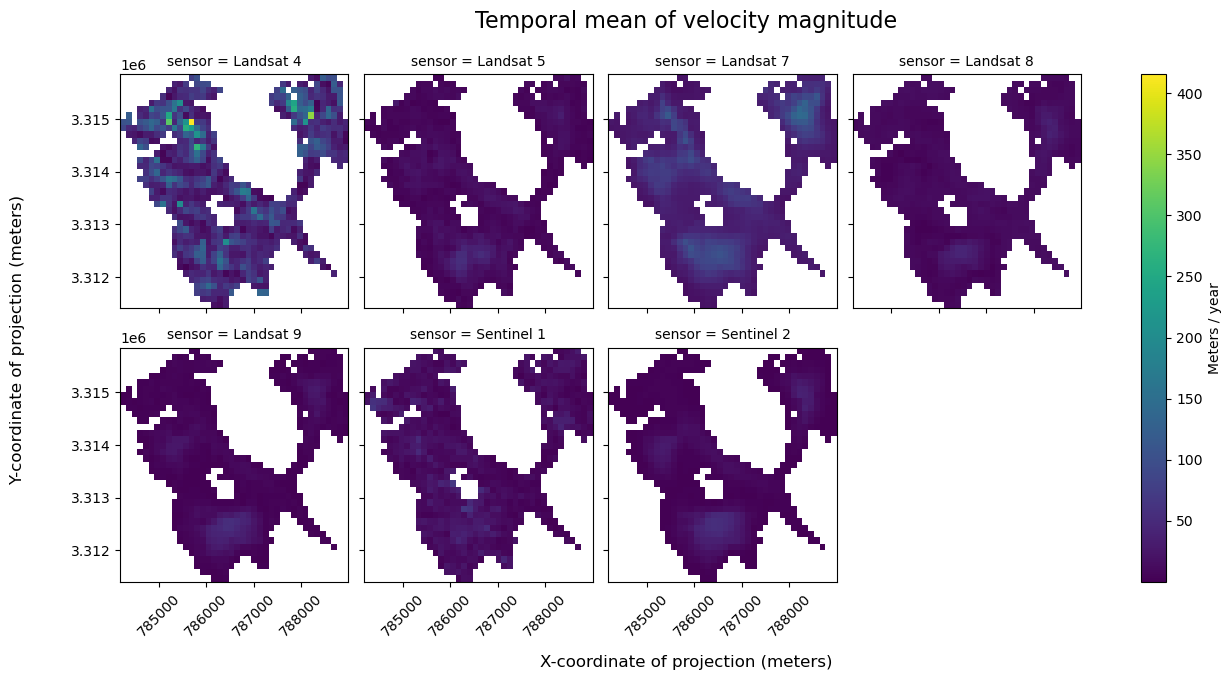

In [38]:
sensor_means = calc_v_magnitude(sensor_means)

a = sensor_means["vmag"].plot(col="sensor", col_wrap=4, cbar_kwargs={"label": "Meters / year"})
a.fig.suptitle("Temporal mean of velocity magnitude", fontsize=16, y=1.05)
a.fig.supylabel("Y-coordinate of projection (meters)", fontsize=12, x=-0.02)
a.fig.supxlabel("X-coordinate of projection (meters)", fontsize=12, y=-0.05)

# remove individual axes labesl
for i in range(len(a.axs[0])):
    a.axs[0][i].set_ylabel(None)
    a.axs[0][i].set_xlabel(None)

for i in range(len(a.axs[1])):
    a.axs[1][i].set_ylabel(None)
    a.axs[1][i].set_xlabel(None)
    a.axs[1][i].tick_params(axis="x", labelrotation=45)

#### Choosing an approach

The two paradigms, hierarchical Datatree and groupby, are equivalent ways of solving the problem. Choose the approach that makes most sense for your analysis. In this case our analysis is a simple operation (`mean`) and the result is a regular 3D array, so the groupby approach is less complex. For more complicated datasets, for example those where each sensor is a separate cube on a different grid, the Datatree approach is more appropriate and ergonomic.

## C. Examine velocity variability

### {{c1_its_nb4}}

First, we plot histogram of the `v`, `vx` and `vy` variables to examine their distributions. To construct these plots, we use a combination of xarray plotting functionality and matplotlib object-oriented plotting. In addition, we use [`xr.reduce()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.reduce.html) and [`scipy.stats.skew()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) to calculate the skew of each variable (inset in each sub-plot).

To make things easier, write a function that calculates and hold summary statistics for each variable in a dictionary:

In [39]:
def calc_summary_stats(ds: xr.Dataset, variable: str):
    """I'm a function that calculates summary statistics for a given data variable and returns them as a dict to be used in a plot"""

    skew = ds[f"{variable}"].reduce(func=scipy.stats.skew, nan_policy="omit", dim=["x", "y", "mid_date"]).data
    mean = ds[f"{variable}"].mean(dim=["x", "y", "mid_date"], skipna=True).data
    median = ds[f"{variable}"].median(dim=["x", "y", "mid_date"], skipna=True).data

    stats_dict = {"skew": skew, "mean": mean, "median": median}
    return stats_dict

In [40]:
stats_vy = calc_summary_stats(single_glacier_raster, "vy")
stats_vx = calc_summary_stats(single_glacier_raster, "vx")
stats_v = calc_summary_stats(single_glacier_raster, "v")

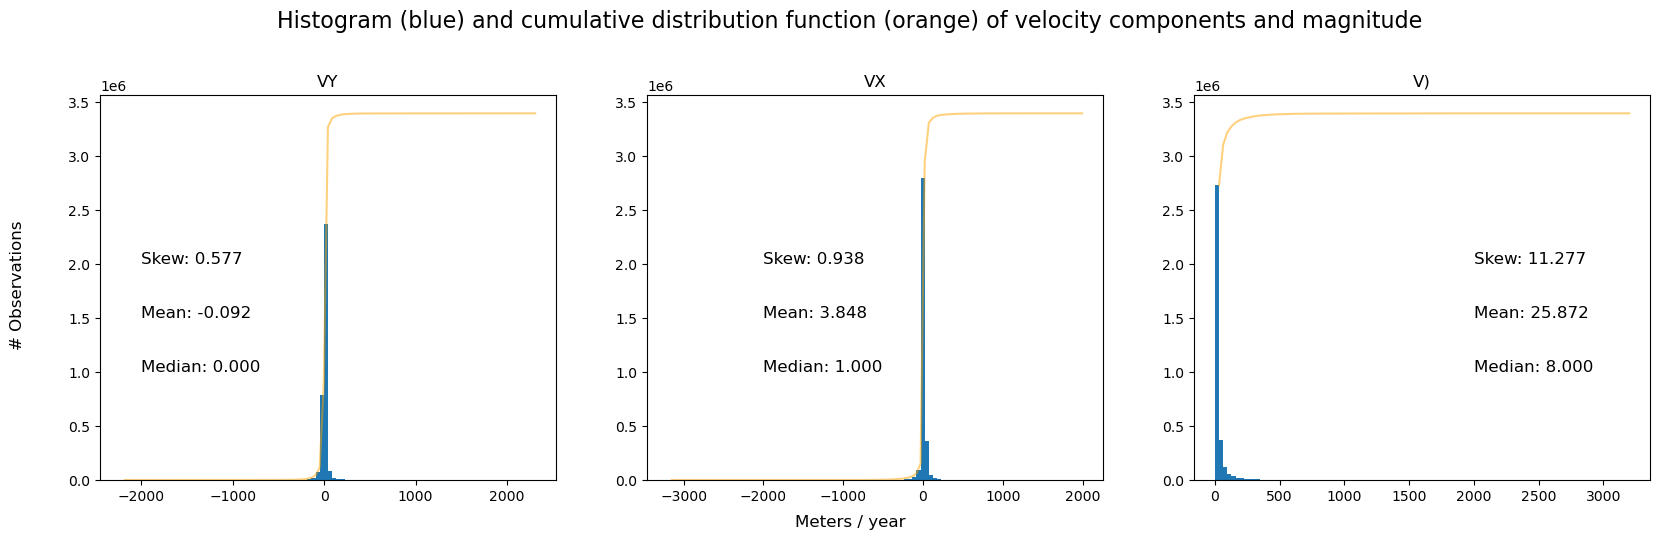

In [41]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
# VY
hist_y = single_glacier_raster.vy.plot.hist(ax=axs[0], bins=100)
cumulative_y = np.cumsum(hist_y[0])
axs[0].plot(hist_y[1][1:], cumulative_y, color="orange", linestyle="-", alpha=0.5)
# VY stats text
axs[0].text(x=-2000, y=2e6, s=f"Skew: {stats_vy['skew']:.3f}", fontsize=12, color="black")
axs[0].text(x=-2000, y=1.5e6, s=f"Mean: {stats_vy['mean']:.3f}", fontsize=12, color="black")
axs[0].text(x=-2000, y=1e6, s=f"Median: {stats_vy['median']:.3f}", fontsize=12, color="black")

# VX
hist_x = single_glacier_raster.vx.plot.hist(ax=axs[1], bins=100)
cumulative_x = np.cumsum(hist_x[0])
axs[1].plot(hist_x[1][1:], cumulative_x, color="orange", linestyle="-", alpha=0.5)
# VX stats text
axs[1].text(x=-2000, y=2e6, s=f"Skew: {stats_vx['skew']:.3f}", fontsize=12, color="black")
axs[1].text(x=-2000, y=1.5e6, s=f"Mean: {stats_vx['mean']:.3f}", fontsize=12, color="black")
axs[1].text(x=-2000, y=1e6, s=f"Median: {stats_vx['median']:.3f}", fontsize=12, color="black")

# V
hist_v = single_glacier_raster.v.plot.hist(ax=axs[2], bins=100)
cumulative_v = np.cumsum(hist_v[0])
axs[2].plot(hist_v[1][1:], cumulative_v, color="orange", linestyle="-", alpha=0.5)
# V stats text
axs[2].text(x=2000, y=2e6, s=f"Skew: {stats_v['skew']:.3f}", fontsize=12, color="black")
axs[2].text(x=2000, y=1.5e6, s=f"Mean: {stats_v['mean']:.3f}", fontsize=12, color="black")
axs[2].text(x=2000, y=1e6, s=f"Median: {stats_v['median']:.3f}", fontsize=12, color="black")

# Formatting and labeling
axs[0].set_title("VY")
axs[1].set_title("VX")
axs[2].set_title("V)")

for i in range(len(axs)):
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)

fig.supylabel("# Observations", x=0.08, fontsize=12)
fig.supxlabel("Meters / year", fontsize=12)
fig.suptitle(
    "Histogram (blue) and cumulative distribution function (orange) of velocity components and magnitude",
    fontsize=16,
    y=1.05,
);

The histograms and summary statistics show that `vx` and `vy` distributions are relatively Gaussian, while `v` is positively skewed and [Rician](https://en.wikipedia.org/wiki/Rice_distribution). This is due to the non-linear relationship between component and displacement vectors. In datasets such as this one where the signal to noise ratio can be low, calculating velocity magnitude on smoothed or averaged component vectors can help to suppress noise (for a bit more detail, refer to this [comment](https://github.com/e-marshall/itslive/issues/26)). For this reason, we will usually calculate velocity magnitude after the dataset has been reduced over space or time dimensions.

### {{c2_its_nb4}}

Now that we have a greater understanding of the importance of velocity component variability in shaping our understandings of velocity variability, let's examine these variables as well as the estimated error provided in the dataset by reducing the dataset along the temporal dimension so that we can visualize the data along x and y dimensions.

In [42]:
# Calculate min, max for color bar
vmin_y = single_glacier_raster.vy.mean(dim=["mid_date"]).min().data
vmax_y = single_glacier_raster.vy.mean(dim=["mid_date"]).max().data

vmin_x = single_glacier_raster.vx.mean(dim=["mid_date"]).min().data
vmax_x = single_glacier_raster.vx.mean(dim=["mid_date"]).max().data

vmin = min([vmin_x, vmin_y])
vmax = max([vmax_x, vmax_y])

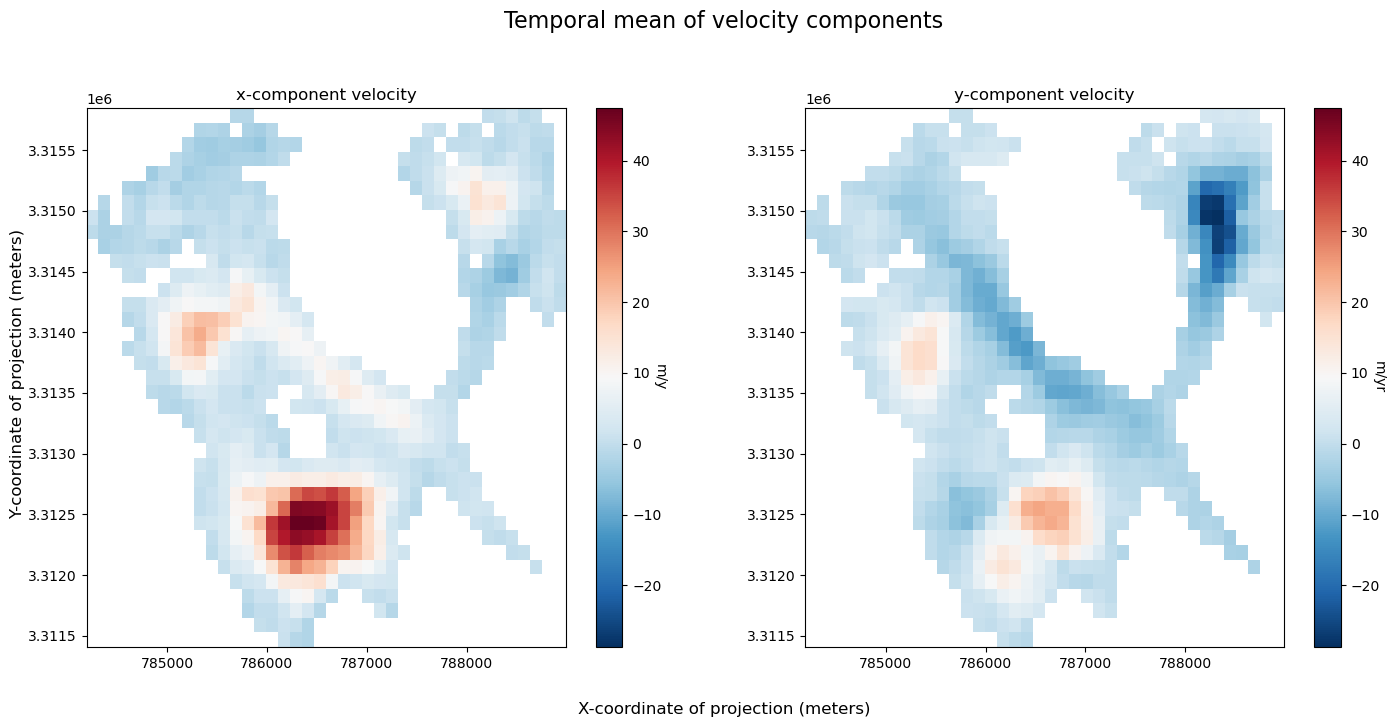

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(17, 7))

x = single_glacier_raster.vx.mean(dim="mid_date").plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap="RdBu_r")
y = single_glacier_raster.vy.mean(dim="mid_date").plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap="RdBu_r")
axs[0].set_title("x-component velocity", fontsize=12)
axs[1].set_title("y-component velocity", fontsize=12)
fig.suptitle("Temporal mean of velocity components", fontsize=16, y=1.02)

x.colorbar.set_label("m/y", rotation=270)
y.colorbar.set_label("m/yr", rotation=270)

for i in range(len(axs)):
    axs[i].set_ylabel(None)
    axs[i].set_xlabel(None)
fig.supylabel("Y-coordinate of projection (meters)", x=0.08, fontsize=12)
fig.supxlabel("X-coordinate of projection (meters)", fontsize=12);

In addition to visualizing components (above), plotting velocity vectors is helpful for understanding magnitude and direction of flow:

First, calculate and visualize mean velocity magnitude over time (we will use the function defined in Part 1), and the mean estimated error over time:

In [44]:
ds_v = calc_v_magnitude(single_glacier_raster.mean(dim="mid_date", skipna=True))

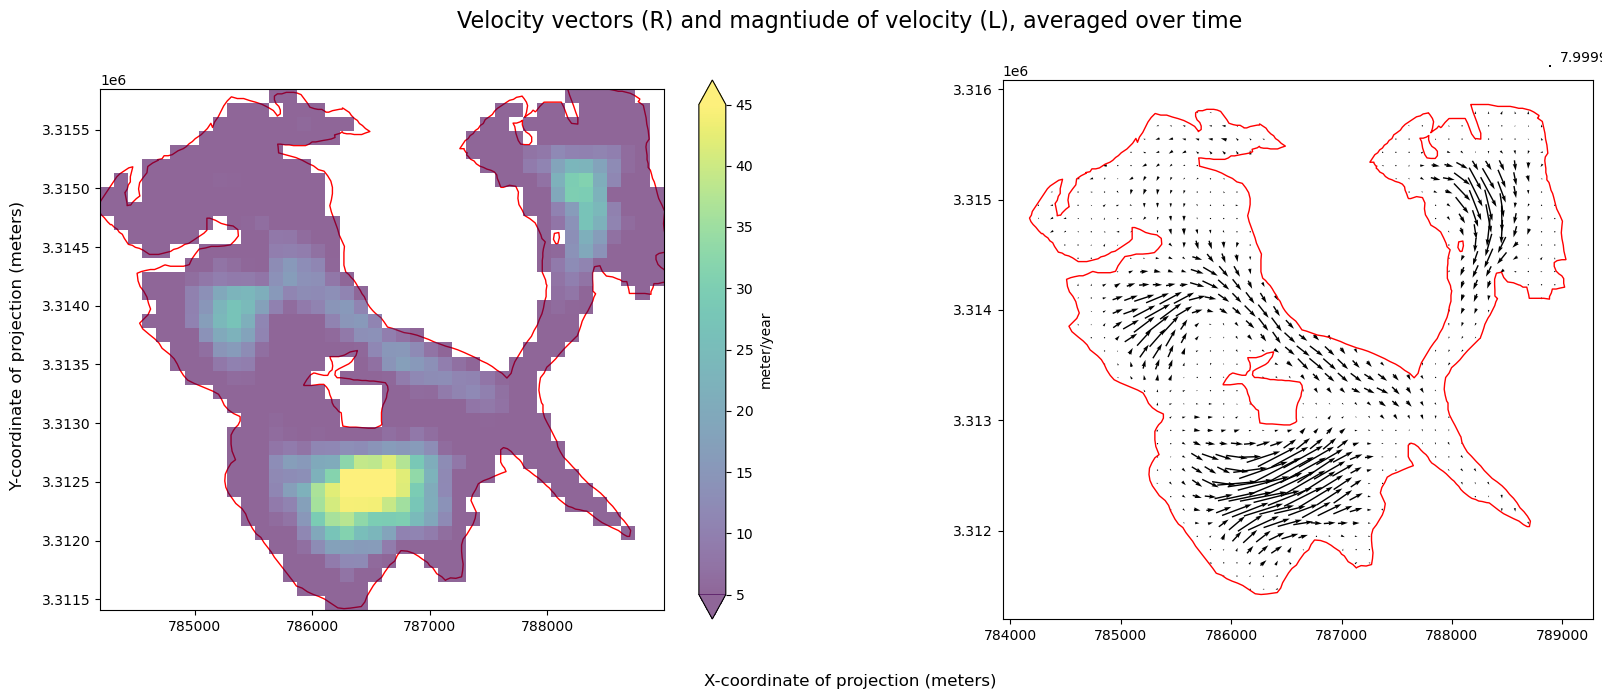

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 7))

single_glacier_vector.plot(ax=axs[0], facecolor="none", edgecolor="red")
single_glacier_raster.mean(dim="mid_date").plot.quiver("x", "y", "vx", "vy", ax=axs[1], angles="xy", robust=True)

single_glacier_vector.plot(ax=axs[1], facecolor="none", edgecolor="red")
a = ds_v["vmag"].plot(ax=axs[0], alpha=0.6, vmax=45, vmin=5)
a.colorbar.set_label("meter/year")

fig.supylabel("Y-coordinate of projection (meters)", x=0.08, fontsize=12)
fig.supxlabel("X-coordinate of projection (meters)", fontsize=12)

fig.suptitle(
    "Velocity vectors (R) and magntiude of velocity (L), averaged over time",
    fontsize=16,
    y=0.98,
)
for i in range(len(axs)):
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].set_title(None)

Visualize magnitude of velocity overlaid with velocity vectors next to velocity error:

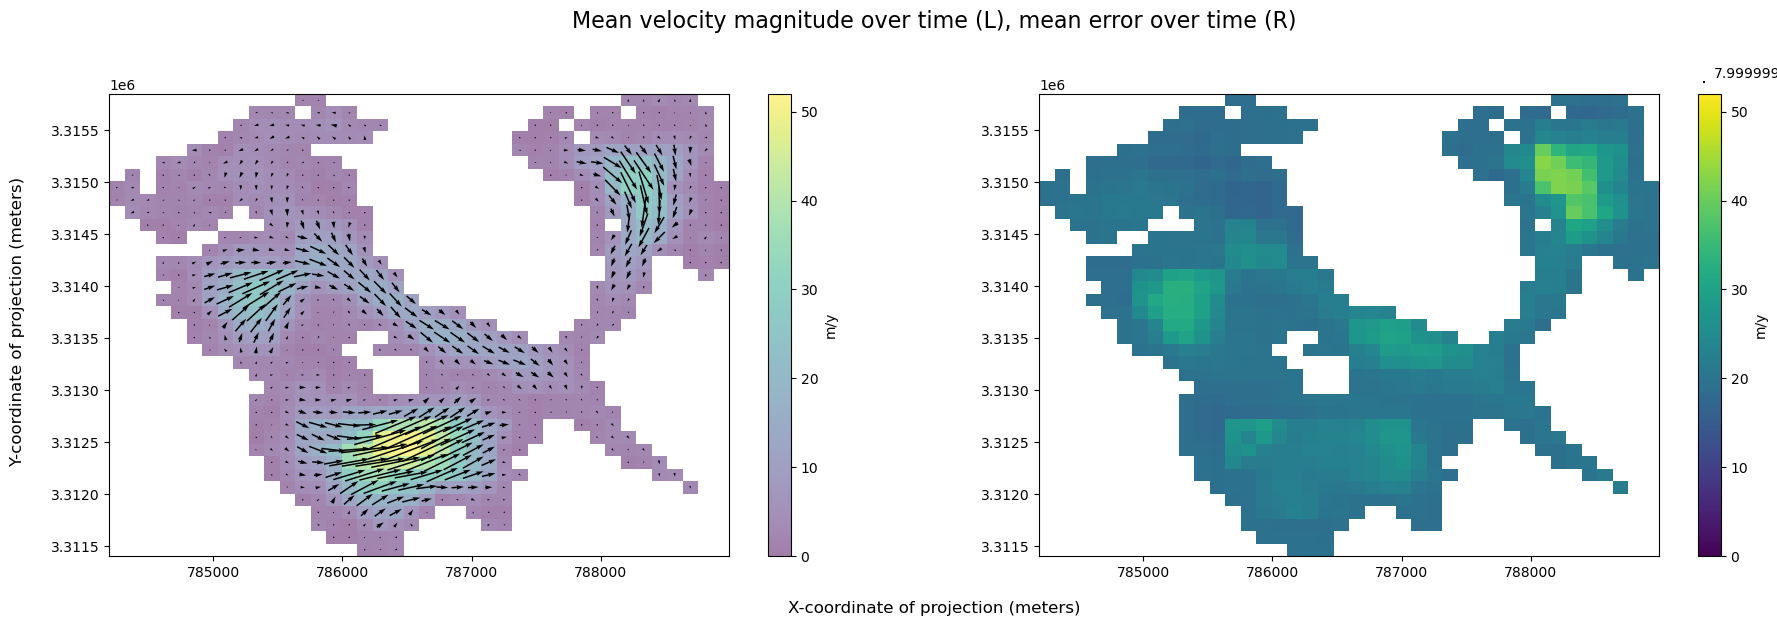

In [46]:
fig, ax = plt.subplots(figsize=(22, 6), ncols=2)

vmag = ds_v.vmag.plot(ax=ax[0], vmin=0, vmax=52, alpha=0.5)
single_glacier_raster.mean(dim="mid_date").plot.quiver("x", "y", "vx", "vy", ax=ax[0], angles="xy", robust=True)

err = ds_v.v_error.plot(ax=ax[1], vmin=0, vmax=52)


vmag.colorbar.set_label("m/y")  # , rotation=270)
err.colorbar.set_label("m/y")  # , rotation=270)

for i in range(len(ax)):
    ax[i].set_ylabel(None)
    ax[i].set_xlabel(None)
    ax[i].set_title(None)

fig.supxlabel("X-coordinate of projection (meters)", fontsize=12)
fig.supylabel("Y-coordinate of projection (meters)", x=0.08, fontsize=12)
fig.suptitle(
    "Mean velocity magnitude over time (L), mean error over time (R)",
    fontsize=16,
    y=1.02,
);

`v_error` is large relative to the magnitude of velocity, suggesting that this data is pretty noisy. 

### {{c3_its_nb4}}

Reduce over the spatial dimensions (this time we will switch it up and choose a different reduction function) and visualize variability over time:

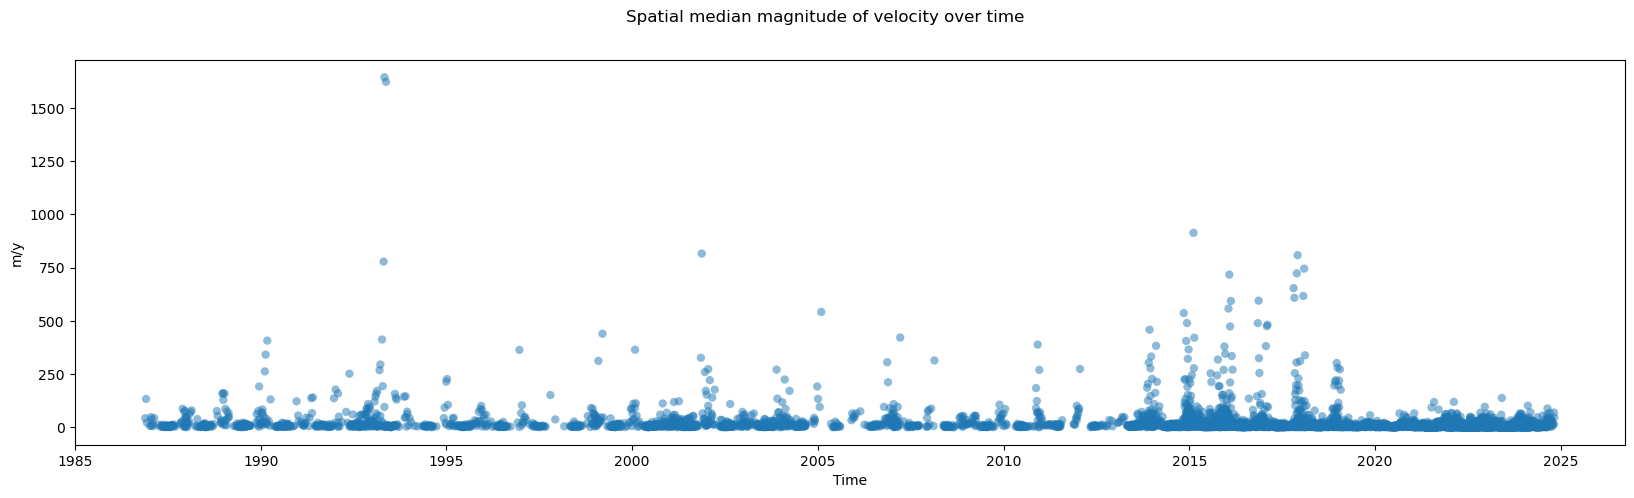

In [47]:
fig, ax = plt.subplots(figsize=(20, 5))

vmag_med = calc_v_magnitude(single_glacier_raster.median(dim=["x", "y"]))

vmag_med.plot.scatter(x="mid_date", y="vmag", ax=ax, marker="o", edgecolors="None", alpha=0.5)
fig.suptitle("Spatial median magnitude of velocity over time")
ax.set_title(None)
ax.set_ylabel("m/y")
ax.set_xlabel("Time");

This helps get a sense of velocity variability over time, but also shows how many outliers there are, even after taking the median over the x and y dimensions. In the final section of this notebook, we explore different approaches for changing the resolution of the temporal dimension.

## D. Computations  along time dimension

In Part 2, we saw that the timeseries is dense in places and quite noisy. This section demonstrates different approaches for looking at a temporal signal in the dataset.

### {{d1_its_nb4}}

Use Xarray's [`resample()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.resample.html) method to coarsen the temporal resolution of the dataset. With `resample()`, you can upsample or downsample the data, choosing both the resample frequency and the type of reduction.

In [48]:
# Coarsen dataset to monthly
resample_obj = single_glacier_raster.resample(mid_date="2ME")
# Calculate monthly median
glacier_resample_1mo = resample_obj.median(dim="mid_date")

The `mid_date` dimension is now much less dense:

In [49]:
glacier_resample_1mo

<xarray.Dataset> Size: 5MB
Dimensions:      (mid_date: 230, y: 37, x: 40)
Coordinates:
    mapping      int64 8B 0
  * x            (x) float64 320B 7.843e+05 7.844e+05 ... 7.888e+05 7.889e+05
  * y            (y) float64 296B 3.316e+06 3.316e+06 ... 3.312e+06 3.311e+06
    spatial_ref  int64 8B 0
  * mid_date     (mid_date) datetime64[ns] 2kB 1986-09-30 ... 2024-11-30
Data variables:
    v            (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    vx           (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    vy           (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    v_error      (mid_date, y, x) float32 1MB nan nan nan nan ... nan nan nan
    vy_error     (mid_date) float32 920B 30.2 31.45 23.8 28.5 ... 8.0 16.65 26.8
    vx_error     (mid_date) float32 920B 27.4 40.6 24.2 29.9 ... 5.6 9.4 17.5
    cov          (mid_date) float64 2kB 0.0 0.2461 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Compare the 2-month resampled median time series to the full time series we plotted at the end of Part 2:

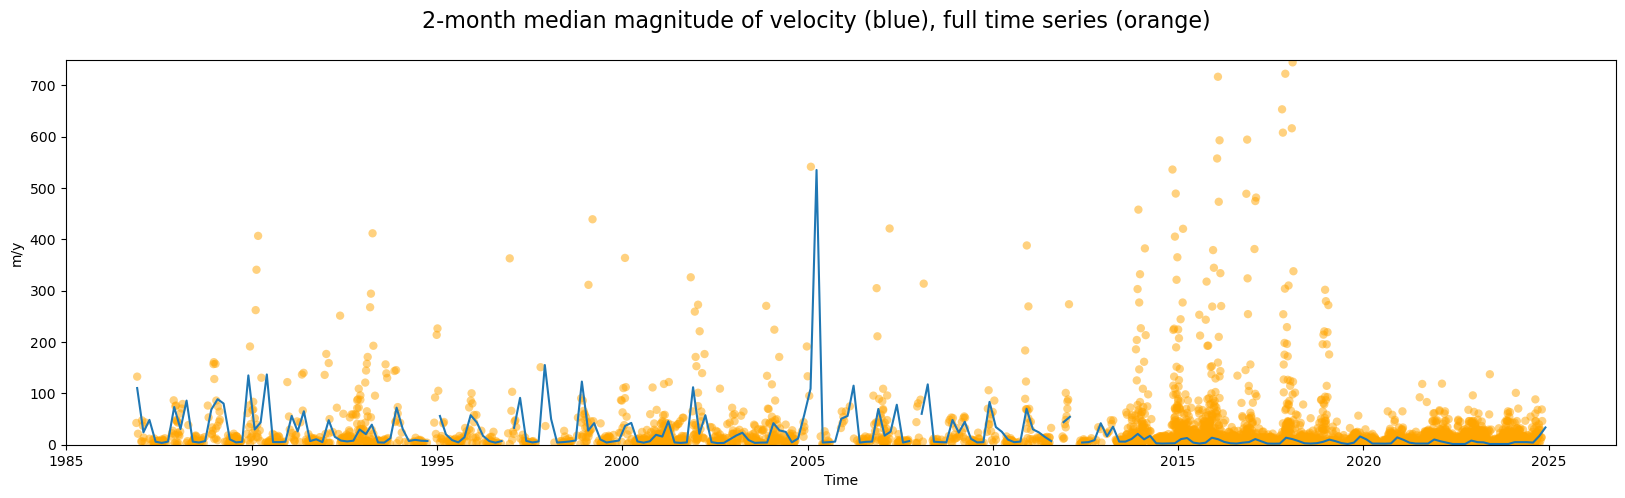

In [50]:
fig, ax = plt.subplots(figsize=(20, 5))

# Calculate magnitude of velocity after the temporal reduction
vmag_1mo = calc_v_magnitude(glacier_resample_1mo)

# Calculate spatial median
vmag_1mo["vmag"].median(dim=["x", "y"]).plot(ax=ax)
# Plot full time series (spatial median) magnitude of velocity
vmag_med.plot.scatter(
    x="mid_date",
    y="vmag",
    ax=ax,
    marker="o",
    edgecolors="None",
    alpha=0.5,
    color="orange",
)
# Labels and formatting
fig.suptitle(
    "2-month median magnitude of velocity (blue), full time series (orange)",
    fontsize=16,
)
ax.set_title(None)
ax.set_ylabel("m/y")
ax.set_xlabel("Time")
ax.set_ylim(0, 750);

We can make a few observations:
- Computing two-month median velocities makes it easier to see a somewhat periodic velocity signal
- As expected, the median is highly sensitive to the density of observations; as such, it displays greater amplitude during periods with sparser observations. When the density of observations increases significantly in 2014, the amplitude of variability of the 2-month median curve decreases dramatically. 

### {{d2_its_nb4}}

Xarray's [`groupby()`](https://docs.xarray.dev/en/stable/user-guide/groupby.html) functionality allows us to segment the dataset into different groups along given dimensions. Here, we use that to analyze seasonal velocity variability patterns:

In [51]:
seasons_gb = single_glacier_raster.groupby(single_glacier_raster.mid_date.dt.season).median()
# add attrs to gb object
seasons_gb.attrs = single_glacier_raster.attrs
# Reorder seasons
seasons_gb = seasons_gb.reindex({"season": ["DJF", "MAM", "JJA", "SON"]})
seasons_gb

<xarray.Dataset> Size: 95kB
Dimensions:      (x: 40, y: 37, season: 4)
Coordinates:
  * x            (x) float64 320B 7.843e+05 7.844e+05 ... 7.888e+05 7.889e+05
  * y            (y) float64 296B 3.316e+06 3.316e+06 ... 3.312e+06 3.311e+06
  * season       (season) <U3 48B 'DJF' 'MAM' 'JJA' 'SON'
    mapping      int64 8B 0
    spatial_ref  int64 8B 0
Data variables:
    v            (season, y, x) float32 24kB nan nan nan nan ... nan nan nan nan
    vx           (season, y, x) float32 24kB nan nan nan nan ... nan nan nan nan
    vy           (season, y, x) float32 24kB nan nan nan nan ... nan nan nan nan
    v_error      (season, y, x) float32 24kB nan nan nan nan ... nan nan nan nan
    vy_error     (season) float32 16B 8.2 4.8 4.2 9.1
    vx_error     (season) float32 16B 5.4 3.4 3.3 6.0
    cov          (season) float64 32B 0.0 0.0 0.0 0.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

This is cool; we've gone from our 3-d object with a very dense `mid_date` dimension to a 3-d object where the temporal aspect of the data is represented by 4 seasons. 

In the above cell, we defined how we wanted to group our data (`single_glacier_raster.mid_date.dt.season`) and the reduction we wanted to apply to each group (`median()`). After the apply step, Xarray automatically combines the groups into a single object with a `season` dimension.

 If you'd like to see another example of this with more detailed explanations, go [here](https://tutorial.xarray.dev/fundamentals/03.2_groupby_with_xarray.html).

In [52]:
# Calculate magnitude on seasonal groupby object
seasons_vmag = calc_v_magnitude(seasons_gb)

Use another `FacetGrid` plot to visualize the seasons side-by-side:

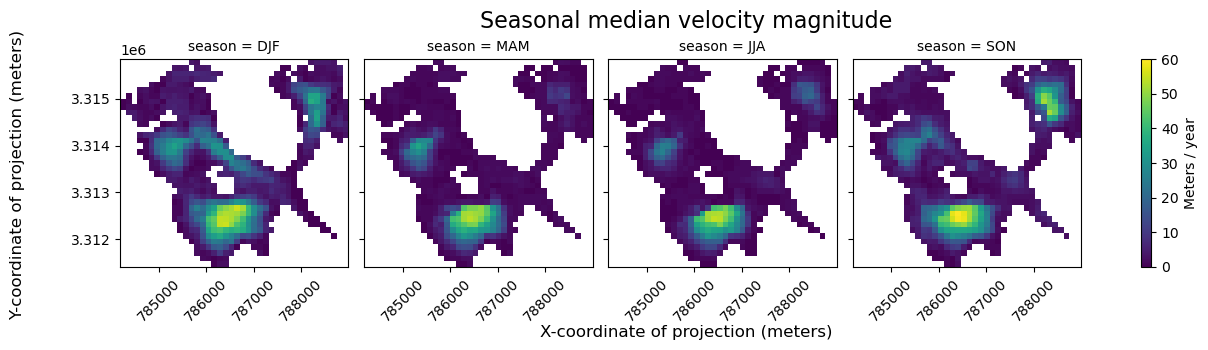

In [53]:
fg = seasons_vmag.vmag.plot(col="season", cbar_kwargs={"label": "Meters / year"})
fg.fig.suptitle("Seasonal median velocity magnitude", fontsize=16, y=1.05)
fg.fig.supxlabel("X-coordinate of projection (meters)", fontsize=12, y=-0.05)
fg.fig.supylabel("Y-coordinate of projection (meters)", fontsize=12, x=-0.02)
for i in range(len(fg.axs[0])):
    fg.axs[0][i].set_ylabel(None)
    fg.axs[0][i].set_xlabel(None)
    fg.axs[0][i].tick_params(axis="x", labelrotation=45)

From the above FacetGrid plot, it appears that some regions of the glacier are very active (show high velocities) throughout the entire year. In other areas, it appears that glacier flow may be much more seasonal.

{{conclusion}}  

This was a primer in exploratory data analysis at the scale of an individual spatial area of interest (in this case, a glacier). The last notebook in this chapter will demonstrate exploratory analysis at a larger spatial scale.